In [ ]:
!pip install clearml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.2 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.10.1
    Uninstalling PyJWT-2.10.1:
      Successfully uninstalled PyJWT-2.10.1


In [ ]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 56.3 MB/s eta 0:00:00


In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import warnings
from clearml import Task, Logger
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=GOAIFA4O10NJTAC12MSZM6VNV26DBP
%env CLEARML_API_SECRET_KEY=uZ3K99JCs_8FOkJN7_lSBBOhSuJCbGQhn9aICJ7nxFK437Pa9Wk2SkKSPbgaop9tWBs

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=GOAIFA4O10NJTAC12MSZM6VNV26DBP
env: CLEARML_API_SECRET_KEY=uZ3K99JCs_8FOkJN7_lSBBOhSuJCbGQhn9aICJ7nxFK437Pa9Wk2SkKSPbgaop9tWBs


In [ ]:
task = Task.init(
    project_name='EMNIST Classification',
    task_name='task1',
    tags=['PyTorch','ClearML'])

ClearML Task: created new task id=ba30924e67be46dca99303b69d8dec86
2024-12-23 00:03:14,796 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/a1ac56f5ac774c4e865b321338a22e01/experiments/ba30924e67be46dca99303b69d8dec86/output/log


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data = torchvision.datasets.EMNIST(root='contents/', download=True, transform=transform, train=True, split='balanced')
test_data = torchvision.datasets.EMNIST(root='contents/', download=True, transform=transform, train=False, split='balanced')

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


100%|██████████| 562M/562M [00:41<00:00, 13.5MB/s]


Extracting contents/EMNIST/raw/gzip.zip to contents/EMNIST/raw


In [ ]:
task.upload_artifact(
    name='train_data',
    artifact_object=train_data)

True

In [ ]:
task.upload_artifact(
    name='test_data',
    artifact_object=test_data)

True

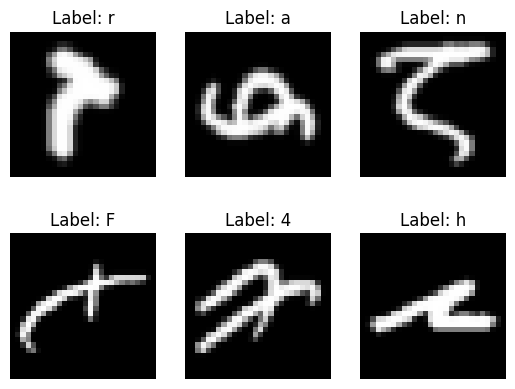

In [ ]:
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(train_data.data[i], cmap='gray')
    plt.title(f"Label: {train_data.classes[train_data.targets[i]]}")
    plt.axis('off')
plt.show()

In [ ]:
class EMNISTModel(pl.LightningModule):
    def __init__(self):
        super(EMNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1)
        self.fc = nn.Linear(64 * 20 * 20, 47)
        self.val_losses = []
        self.val_accuracies = []

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=1)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.nll_loss(outputs, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.nll_loss(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        acc = (predicted == labels).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def on_validation_epoch_end(self):
        # Собираем метрики после завершения эпохи
        val_loss = self.trainer.callback_metrics["val_loss"]
        val_acc = self.trainer.callback_metrics["val_acc"]
        self.val_losses.append(val_loss.item())
        self.val_accuracies.append(val_acc.item())

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.001)

model = EMNISTModel()

In [ ]:
trainer = pl.Trainer(max_epochs=10, accelerator="gpu" if torch.cuda.is_available() else "cpu")


trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)


trainer.validate(model, dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | conv1 | Conv2d | 832    | train
1 | conv2 | Conv2d | 51.3 K | train
2 | fc    | Linear | 1.2 M  | train
-----------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.021     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7881914973258972     │
│         val_loss          │    0.7084720134735107     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.7084720134735107, 'val_acc': 0.7881914973258972}]

In [ ]:
device

device(type='cuda')

Validation Losses: [3.859524726867676, 1.532469630241394, 1.3455976247787476, 1.2697569131851196, 1.1902258396148682, 1.0425173044204712, 0.992607831954956, 0.9058653712272644, 0.8124897480010986, 0.7475518584251404, 0.7084720134735107, 0.7084720134735107]
Validation Accuracies: [0.0234375, 0.5610106587409973, 0.6196276545524597, 0.6439893841743469, 0.6610106229782104, 0.7037234306335449, 0.7177127599716187, 0.7403191328048706, 0.759734034538269, 0.781595766544342, 0.7881914973258972, 0.7881914973258972]


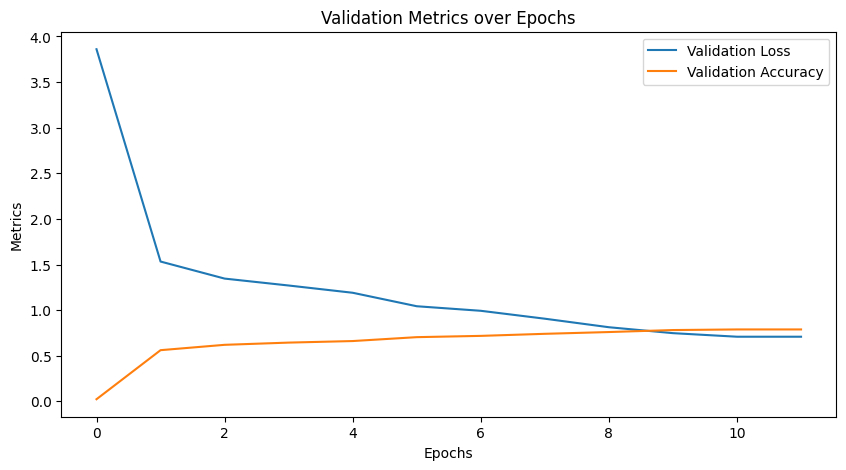

In [ ]:
print("Validation Losses:", model.val_losses)
print("Validation Accuracies:", model.val_accuracies)

# Построение графиков
plt.figure(figsize=(10, 5))
plt.plot(model.val_losses, label='Validation Loss')
plt.plot(model.val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Validation Metrics over Epochs')
plt.legend()
plt.show()